<a href="https://colab.research.google.com/github/darshanvjani/ERA_vision_nlp_ai/blob/main/Advanced%20Convolutions%2C%20Data%20Augmentation%20and%20Visualization/Session_9.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%cd /content/drive/MyDrive/ERA/Advance Convolution and augmentation

/content/drive/MyDrive/ERA/Advance Convolution and augmentation


In [2]:
%matplotlib inline

In [3]:
!pip install albumentations==1.0.0
import albumentations as A

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.1/98.1 kB 2.5 MB/s eta 0:00:00
  Attempting uninstall: albumentations
    Found existing installation: albumentations 1.2.1
    Uninstalling albumentations-1.2.1:
      Successfully uninstalled albumentations-1.2.1


In [4]:
import torch
import torchvision
import torch.nn as nn
import torchvision.transforms as transforms
import albumentations
from albumentations.pytorch import ToTensorV2
import numpy as np
import torchvision.datasets as datasets
import torchvision.utils as utils

from model_1 import Net
from utils import *
from train import *

In [5]:
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform = transforms.ToTensor())

trainloader = torch.utils.data.DataLoader(trainset, batch_size=64,
                                          shuffle=True, num_workers=2)

Files already downloaded and verified


In [6]:
mean, std = get_mean_std(trainloader)

print(mean, std)

tensor([0.4914, 0.4822, 0.4466]) tensor([0.2470, 0.2435, 0.2616])


In [7]:
horizontalflip_prob = 0.2
rotate_limit = 15
shiftscalerotate_prob = 0.25
num_holes = 1
cutout_prob = 0.5

train_transforms, test_transforms = data_albumentations(horizontalflip_prob, rotate_limit, shiftscalerotate_prob, num_holes, cutout_prob, trainloader)

In [8]:
train_set = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform = train_transforms)

test_set  = datasets.CIFAR10(root='./data', train=False,
                                download=True, transform=test_transforms)


train_loader = torch.utils.data.DataLoader(train_set,
                                          batch_size=64,
                                          shuffle=True,
                                          num_workers=2,
                                          pin_memory=True)

test_loader = torch.utils.data.DataLoader(test_set,
                                            batch_size=64,
                                            shuffle=False,
                                            num_workers=2,
                                            pin_memory=True)

Files already downloaded and verified
Files already downloaded and verified


In [9]:
mean, std = get_mean_std(train_loader)

print(mean, std)

tensor([-0.0015,  0.0025,  0.0027]) tensor([0.9330, 0.9330, 0.9353])


##PLOT IMAGE

Original Images

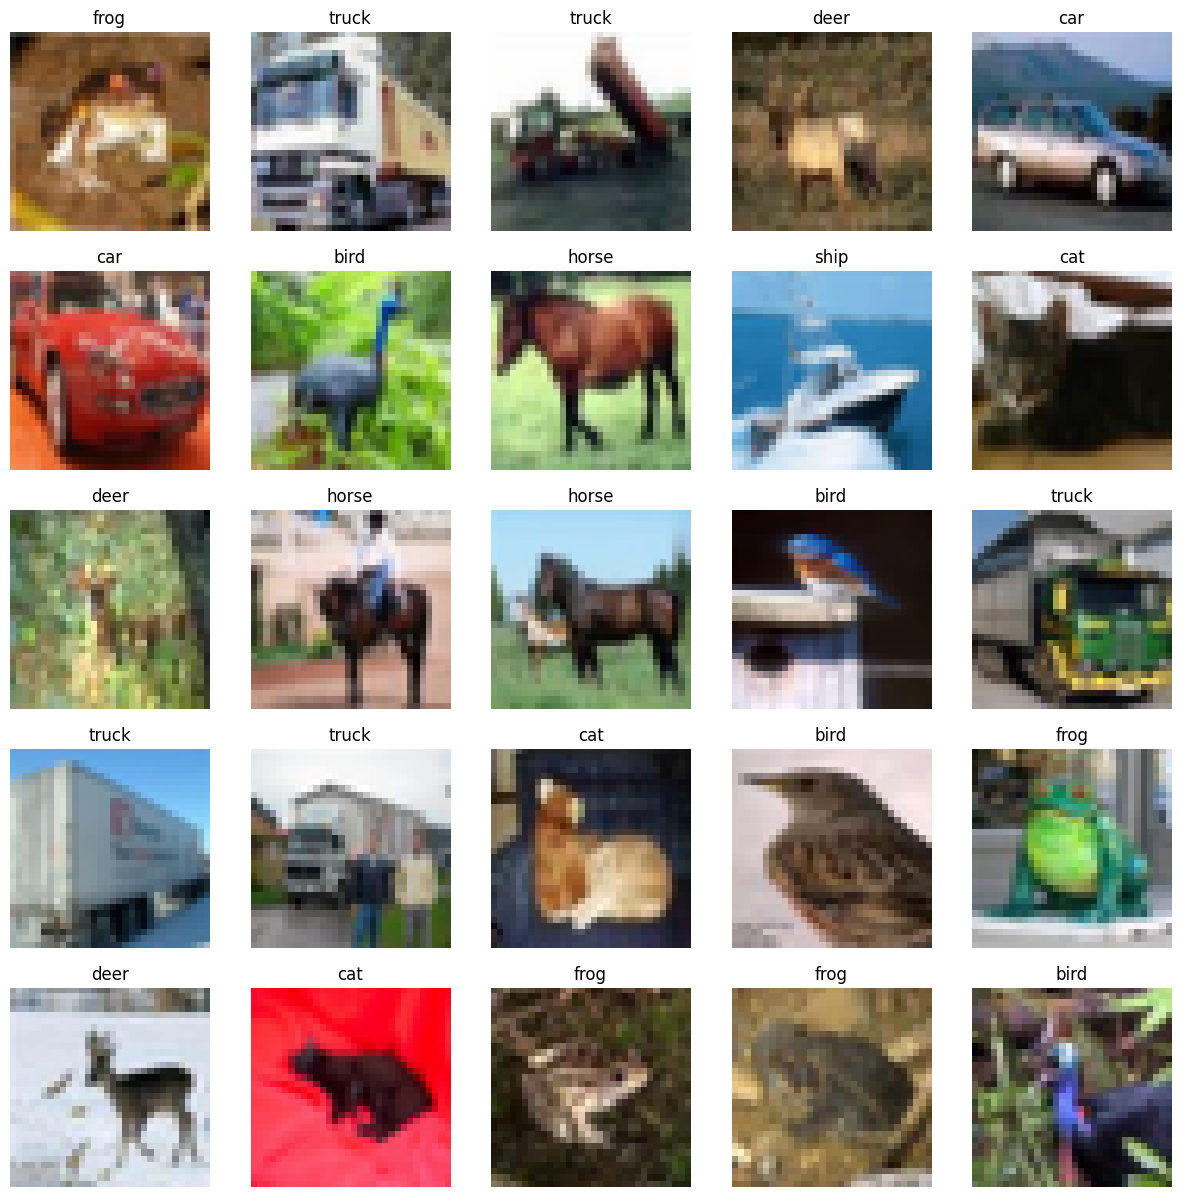

In [10]:
N_IMAGES = 25

classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

images, labels = zip(*[(image, label) for image, label in [trainset[i] for i in range(N_IMAGES)]])

plot_images(images, labels, classes)

Augmented Images

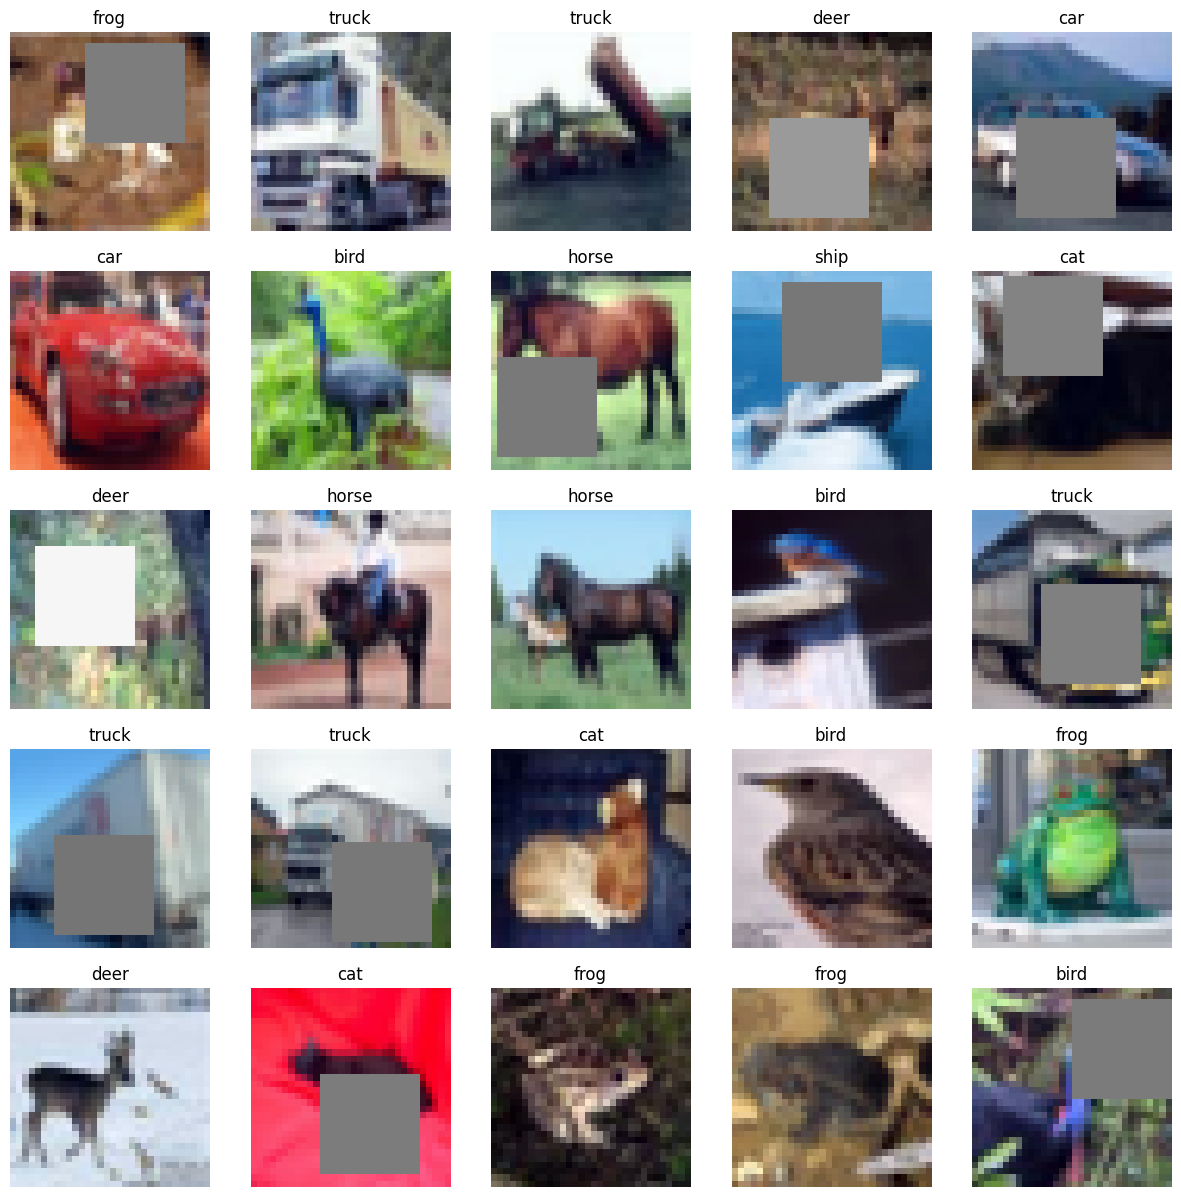

In [11]:
images, labels = zip(*[(image, label) for image, label in [train_set[i] for i in range(N_IMAGES)]])

plot_images(images, labels, classes)

In [12]:
net = Net()

In [13]:
from torchsummary import summary
summary(net.cuda(), (3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 32, 32]             432
              ReLU-2           [-1, 16, 32, 32]               0
       BatchNorm2d-3           [-1, 16, 32, 32]              32
           Dropout-4           [-1, 16, 32, 32]               0
            Conv2d-5           [-1, 32, 34, 34]           4,608
              ReLU-6           [-1, 32, 34, 34]               0
       BatchNorm2d-7           [-1, 32, 34, 34]              64
           Dropout-8           [-1, 32, 34, 34]               0
            Conv2d-9           [-1, 16, 17, 17]           4,608
           Conv2d-10           [-1, 32, 17, 17]           4,608
             ReLU-11           [-1, 32, 17, 17]               0
      BatchNorm2d-12           [-1, 32, 17, 17]              64
          Dropout-13           [-1, 32, 17, 17]               0
           Conv2d-14           [-1, 64,

##Training

In [14]:
import numpy as np
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = [15, 6]

train_loss_dict = dict()
test_loss_dict = dict()

train_accuracy_dict = dict()
test_accuracy_dict = dict()

def training_curves():
  plt.subplot(1,2, 1)

  plt.plot(np.array(test_accuracy_log))
  plt.plot(np.array(train_accuracy_log), 'r')
  plt.legend(["test_acc", "train_acc"])
  plt.title("Accuracy per epoch")

  plt.subplot(1,2,2)
  plt.plot(test_loss_log)
  plt.plot(train_loss_log, 'r')
  plt.legend(["test_loss", "train_loss"])
  plt.title("Loss per epoch")

###BN

In [15]:
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.optim.lr_scheduler import ExponentialLR, OneCycleLR


test_accuracy_log = []
train_accuracy_log = []

test_loss_log = []
train_loss_log = []


l1_factor = 0
l2_factor = 0.0001

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr = 1e-3) #, weight_decay=l2_factor

epochs = 50

# scheduler2 =ReduceLROnPlateau(optimizer=optimizer, verbose=True)
scheduler = OneCycleLR(optimizer, max_lr=0.01, steps_per_epoch=782, epochs=epochs)   # steps_per_epoch = len(train_loader)


EPOCHS = epochs

device = 'cuda' if torch.cuda.is_available() else 'cpu'
best_valid_loss = float('inf')


for epoch in range(EPOCHS):

    train_loss, train_acc = train(net, train_loader, optimizer, scheduler, criterion, l1_factor, device)
    valid_loss, valid_acc = evaluate(net, test_loader, criterion, device)

    train_accuracy_log.append(train_acc)
    test_accuracy_log.append(valid_acc)

    train_loss_log.append(train_loss)
    test_loss_log.append(valid_loss)

    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(net.state_dict(), '96K-model.pth')

    print(f'Epoch: {epoch+1:02} ')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')

train_accuracy_dict[0] = train_accuracy_log
test_accuracy_dict[0] = test_accuracy_log

train_loss_dict[0] = train_loss_log
test_loss_dict[0] = test_loss_log

Epoch: 01 
	Train Loss: 1.536 | Train Acc: 43.73%
	 Val. Loss: 1.210 |  Val. Acc: 56.45%
Epoch: 02 
	Train Loss: 1.245 | Train Acc: 54.85%
	 Val. Loss: 1.034 |  Val. Acc: 63.01%
Epoch: 03 
	Train Loss: 1.136 | Train Acc: 59.33%
	 Val. Loss: 0.971 |  Val. Acc: 64.99%
Epoch: 04 
	Train Loss: 1.065 | Train Acc: 62.09%
	 Val. Loss: 0.922 |  Val. Acc: 67.95%
Epoch: 05 
	Train Loss: 1.026 | Train Acc: 63.85%
	 Val. Loss: 0.840 |  Val. Acc: 70.42%
Epoch: 06 
	Train Loss: 0.999 | Train Acc: 64.75%
	 Val. Loss: 0.833 |  Val. Acc: 70.90%
Epoch: 07 
	Train Loss: 0.969 | Train Acc: 65.79%
	 Val. Loss: 0.791 |  Val. Acc: 72.31%
Epoch: 08 
	Train Loss: 0.942 | Train Acc: 66.86%
	 Val. Loss: 0.813 |  Val. Acc: 72.69%
Epoch: 09 
	Train Loss: 0.926 | Train Acc: 67.72%
	 Val. Loss: 0.748 |  Val. Acc: 74.18%
Epoch: 10 
	Train Loss: 0.912 | Train Acc: 67.94%
	 Val. Loss: 0.797 |  Val. Acc: 72.17%
Epoch: 11 
	Train Loss: 0.894 | Train Acc: 68.51%
	 Val. Loss: 0.740 |  Val. Acc: 74.51%
Epoch: 12 
	Train Los

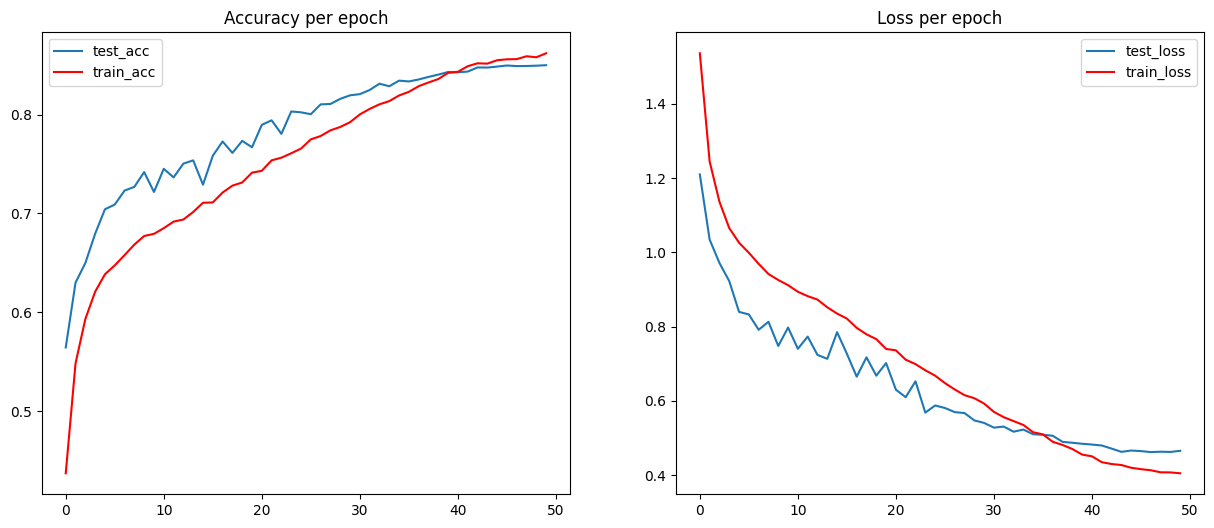

In [16]:
training_curves()

##Checking Misclassified Images

In [17]:
def imshow(img):
    # img = img*[0.4914, 0.4821, 0.4466] +  [0.2470, 0.2435, 0.2616]     # unnormalize
    img[0] = img[0]*0.4914 + 0.2470
    img[1] = img[1]*0.4821 + 0.2435
    img[2] = img[2]*0.4466 + 0.2616
    npimg = img.numpy()
    image = np.transpose(npimg, (1, 2, 0))
    plt.imshow(image)  # removed reshape here
    plt.grid(False)
    return image


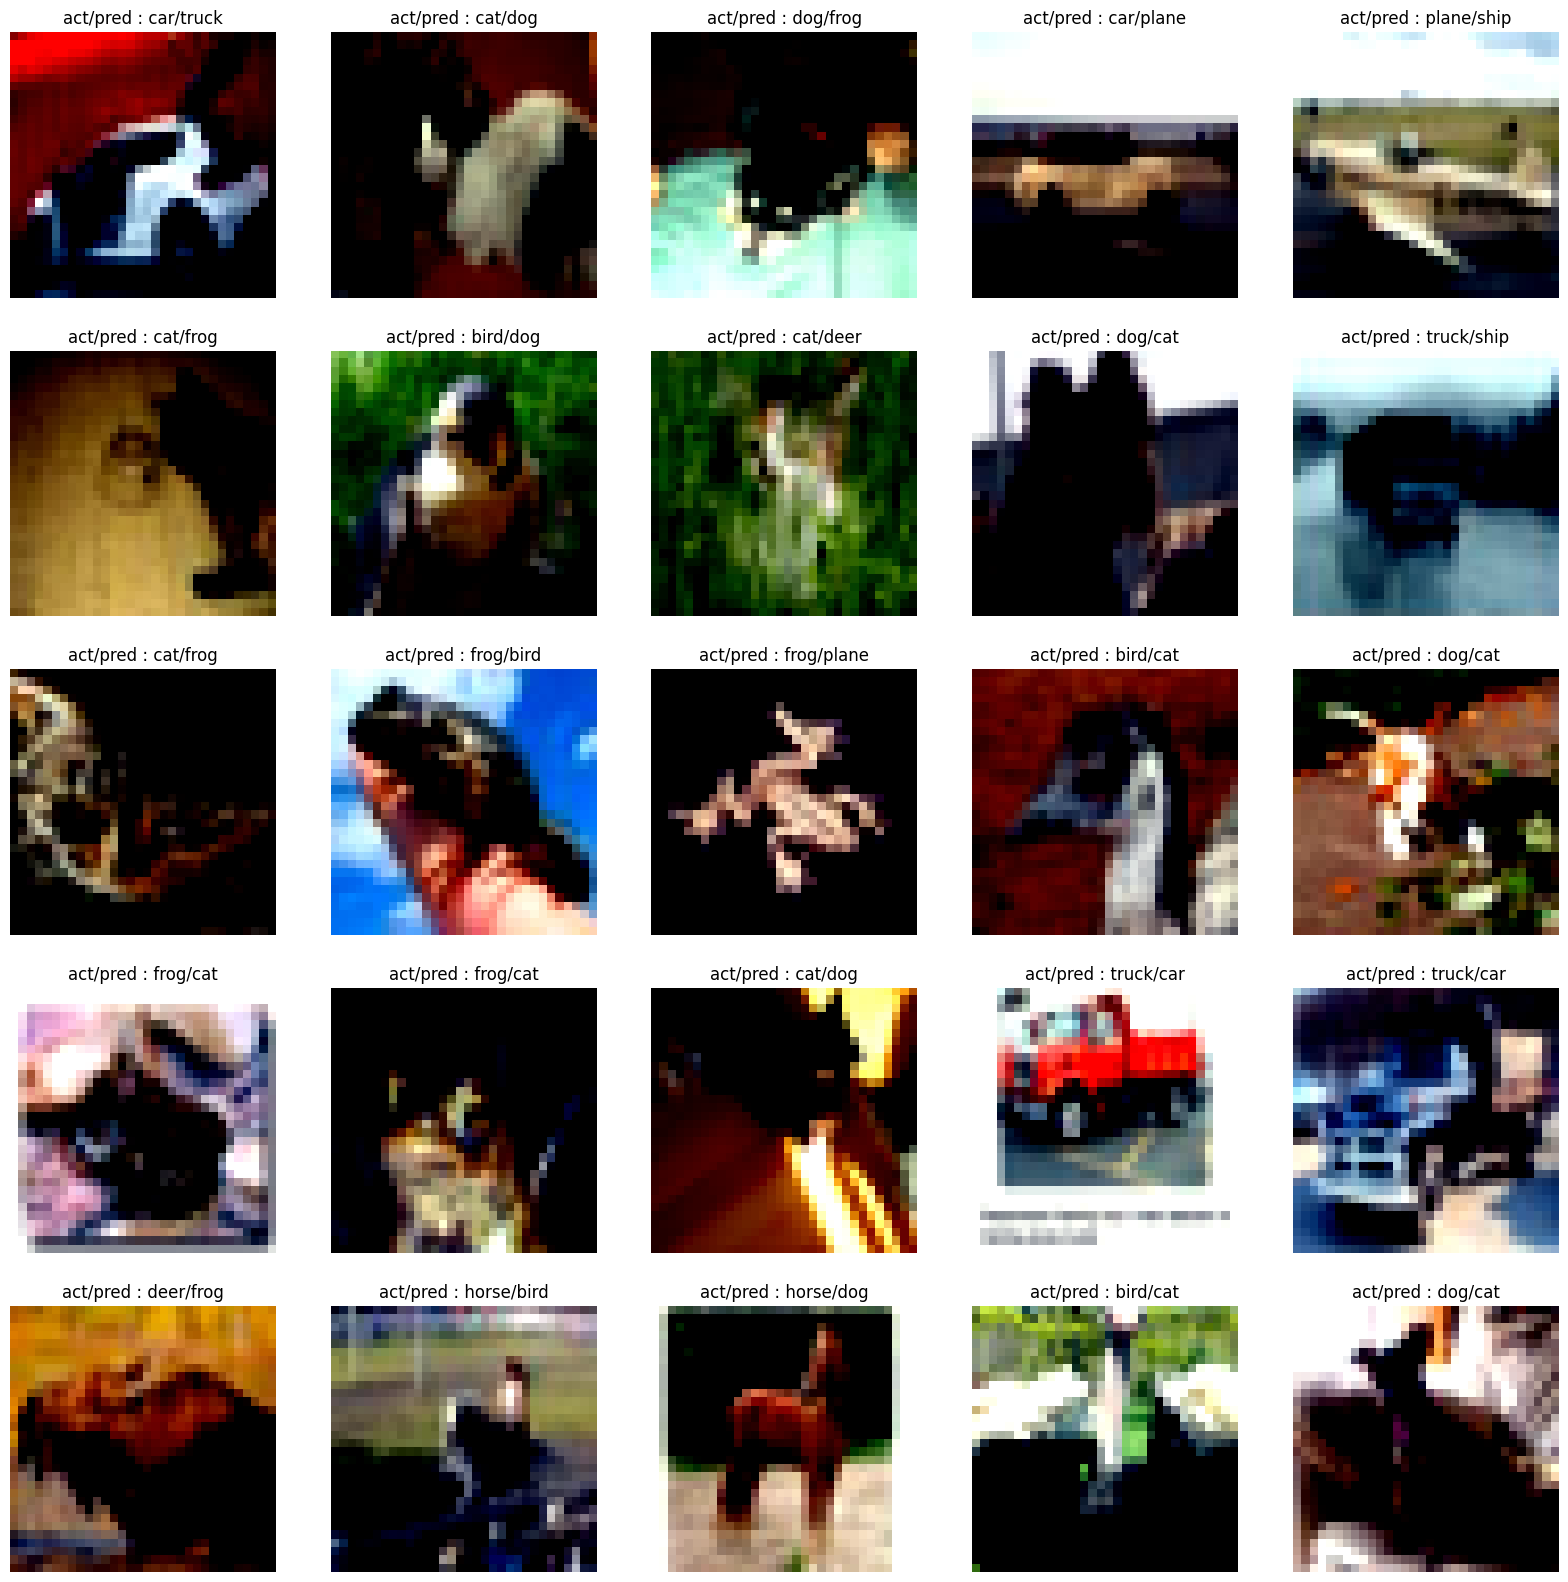

In [18]:
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

net.eval()

figure = plt.figure(figsize=(20, 20))
num_of_images = 25
index = 1

misclass_img_list = []
untrans_img=[]

with torch.no_grad():
    for data, target in test_loader:
        data, target = data.to(
            device), target.to(device)
        output = net(data)
        pred = output.argmax(dim=1, keepdim=True)
        act = target.view_as(pred)
        # since most of the bool vec is true (good problem to have) and switch (flip) the true to false and vice versa
        bool_vec = ~pred.eq(act)

        # now extract the index number from the tensor which has 'true'
        idx = list(
            np.where(bool_vec.cpu().numpy())[0])

        if idx:  # if not a blank list
            idx_list = idx
            # print(data[idx_list[0]].shape)
            if index < num_of_images+1:
                plt.subplot(5, 5, index)
                plt.axis('off')
                titl = 'act/pred : ' + \
                    str(classes[target[idx[0]].cpu().item(
                    )]) + '/' + str(classes[pred[idx[0]].cpu().item()])
                # prints the 1st index of each batch.

                img = data[idx[0]].cpu()
                untrans_img.append(img)
                image = imshow(img)
                misclass_img_list.append(image)



                plt.title(titl)
                index += 1